0) **Imports**

In [1]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


1) **Consititutive behaviour**

In [2]:
# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
nu = 0.3 
E = 100.0 
lamb, mu = youngPoisson2lame(nu, E) 

sigma_law = lambda u: lamb*df.div(u)*df.Identity(2) + mu*(df.grad(u) + df.grad(u).T)

2) **Mesh**  

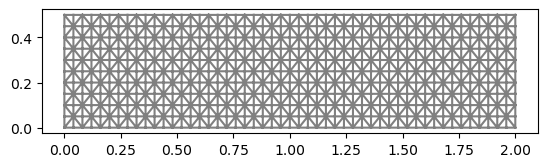

In [3]:
Nx =  50 
Ny =  10 
Lx = 2.0
Ly = 0.5
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
df.plot(mesh);

3) **Mesh regions** 

In [4]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

clampedBndFlag = 1
loadBndFlag = 2
boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, clampedBndFlag)
rightBnd.mark(boundary_markers, loadBndFlag)

dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces**

In [5]:
Uh = df.VectorFunctionSpace(mesh, "CG", 1) # Equivalent to CG
bcL = df.DirichletBC(Uh, df.Constant((0.0, 0.0)), boundary_markers, clampedBndFlag)

5) **Variational Formulation**: <br>

Strong format: 
$$
\begin{cases}
div \sigma = 0 \quad \text{in} \, \Omega \\
u = 0 \quad \text{on} \, \Gamma_1 \\
\varepsilon = \nabla^s u \quad \text{in} \, \Omega \\
\sigma  = \hat{\sigma}(\varepsilon) \quad \text{in} \, \Omega \\
\sigma  n  = t \quad \text{on} \, \Gamma_2 \\
\end{cases}
$$ 

Weak format: find $u \in U = \{ w \in H^1(\Omega) ; w|_{\Gamma_1} = 0 \}$ s.t.
$$
a(u, v) = b(v) \quad \forall v \in U,
$$
with
$$
\begin{cases}
a(u, v) = \int_{\Omega} \sigma(u) \cdot \nabla^s v \, dx \\
b(v) = \int_{\Gamma_2} t \cdot v \, ds \\
\end{cases}
$$

Galerkin method : find $u_h \in U_h \subset U$ s.t.
$$
a(u_h, v_h) = b(v_h) \quad \forall v_h \in U_h,
$$


In [6]:
ty = -0.1
traction = df.Constant((0.0, ty))

In [7]:
u = df.TrialFunction(Uh) 
v = df.TestFunction(Uh)
a = df.inner(sigma_law(u),  df.grad(v))*dx
b = df.inner(traction,v)*ds(loadBndFlag)

6) **Solving**

In [8]:
uh = df.Function(Uh)
problem = df.LinearVariationalProblem(a, b, uh, [bcL])
solver = df.LinearVariationalSolver(problem)
solver.solve()
print("Norm L2: ", df.assemble(df.inner(uh,uh)*dx))
assert np.allclose(df.assemble(df.inner(uh,uh)*dx), 0.0034646449802898404) # test for Nx = 50, Ny = 10

Solving linear variational problem.
Norm L2:  0.0034646449802898404


7) **Plotting**

In [11]:
import fetricks.fenics.postprocessing.wrapper_io as iofe
from fetricks import symgrad_mandel, tensor2mandel

Sh = df.VectorFunctionSpace(mesh, "DG", 0, dim = 3) 
epsh = df.project( symgrad_mandel(uh), Sh)
sig = sigma_law(uh)
sigh = df.project( tensor2mandel(sig), Sh)

uh.rename("u",'')
epsh.rename("eps",'')
sigh.rename("sig",'')

iofe.exportXDMF_gen("bar_vtk.xdmf", fields={'vertex': [uh], 'cell_vector': [epsh, sigh] })
iofe.exportXDMF_checkpoint_gen("bar_sol.xdmf", fields={'vertex': [uh], 'cell': [epsh, sigh] })